[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/Homeworks/blob/main/Task_3.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [1]:
# Импорт библиотек
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import plotly
import plotly.express as px
from turtle import title
import math

In [2]:
# Ограничение вывода строк на экран
pd.options.display.max_rows = 120

# Формирование датасета

## Список объектов

In [3]:
class DomIdLoader:
    def __init__(self):
        # Задание параметров: начальное смещение равно 1, количество записей в блоке равно 100
        self.offset_ = 0
        self.limit_ = 100
        # Пустой список ID объектов
        self.list_IDs = []
   
    def get_ids(self):
        
        
        # Определяем количество строящихся объектов на сайте
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset_}&limit={self.limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        total_obj = res.json().get('data').get('total')

        # Цикл выполняется, пока смещение не превысит общее количество объектов
        while self.offset_ <= total_obj:
                      
            # Выполняем запрос к сайту, выдергиваем json
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset_}&limit={self.limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            res = requests.get(url)

            # Берем ID объектов и добавляем их в список objids
            objects_list = res.json().get('data').get('list')
            self.list_IDs.extend([x.get('objId') for x in objects_list])
            
            # увеличиваем смещение на 100
            self.offset_ += 100
        print('ID строящихся объектов собраны')        
        return self.list_IDs
    
    def show_ids(self):
        print('В списке ' + str(len(self.list_IDs)) + ' IDs строящихся домов')

    def get_ids_and_show_count_IDs(self):
        self.get_ids()
        self.show_ids()
        return self.get_ids


## Данные по определенному объекту

In [4]:
class ObjectInfoExtractor:
    def __init__(self, IDs):
        self.IDs = IDs
        self.df = None

    def load_data(self):
        
        # Список со списками характеристик объектов
        res_full = []

        # Для каждого объекта в списке objids
        for ID_obj in tqdm(self.IDs):
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{ID_obj}'
            # Получение информации
            res = requests.get(url)
            # Добавление в итоговый список
            res_full.append(res.json().get('data'))
            # Создание датафрейма
            self.df = pd.json_normalize(res_full)
        print('Сведения об объектах из списка собраны в датафрейм. Всего ' + str(len(self.df)) + ' объекта(ов).')
        return self.df

    def import_old_data(self):
        """Вариант для экономии времени - загружаем ранее сохраненные данные"""
        self.df = pd.read_pickle('ndrf_df.pkl')
        print('Загружены ранее сохраненные данные. Всего ' + str(len(self.df)) + ' объекта(ов).')


## Сохранение результатов

In [5]:
class Saver:
    def __init__(self, data):
        self.data = data
    
    
    def save_excel(self):
        # Сохранение результатов в excel
        self.data.to_excel("ndrf_df.xlsx", encoding='cp1251')
        print('Данные сохранены в excel.')
    
    def save_csv(self):
        # Сохранение результатов в csv
        self.data.to_csv("ndrf_df.csv")
        print('Данные сохранены в csv.')
    
    def save_pkl(self):
        # Сохранение результатов в pickle
        self.data.to_pickle("ndrf_df.pkl")
        print('Данные сохранены в pickle.')

    def save_sql(self):
        
        # Делаем копию датафрейма (для того, чтобы не преобразовывать тип столбцов исходного датафрейма)
        df_copy = self.data.copy()
        
        # Приведение отдельных столбцов к строковому типу (иначе SQL ругается)
        df_copy['photoRenderDTO'] = df_copy['photoRenderDTO'].astype('str')
        df_copy['objectTransportInfo'] = df_copy['objectTransportInfo'].astype('str')
        df_copy['metro.colors'] = df_copy['metro.colors'].astype('str')
        
        # Создание базы данных SQLite
        con = sqlite3.connect("ndrf_df.db")

        # Сохранение датафрейма в таблицу buildings
        df_copy.to_sql("buildings", con, if_exists="replace", index=False)
        con.commit()
        con.close()
        del df_copy
        print('Данные сохранены в базу данных.')

    def save_all(self):
        self.save_excel()
        self.save_csv()
        self.save_pkl()
        self.save_sql()

# Предобработка датафрейма

In [6]:
class Optimizer_df:
    def __init__(self, data):
        self.data_clean = data
    
    def clean_price(self):
        
        # Удаляем строки, в которых средняя цена за квадратный метр отсутствует
        self.data_clean = self.data_clean[self.data_clean.objPriceAvg.notnull()].copy()
        print('Удалены данные по объектам без цены за кв. метр.')

        # Сбрасываем индекс
        self.data_clean.reset_index(inplace=True)
        del self.data_clean['index']
        
    def drop_nan(self):

        # Удаляем столбцы, в которых пропущено более 90% значения
        self.data_clean.dropna(thresh=(0.1*len(self.data_clean)), axis=1, inplace=True)
        print('Удалены столбцы, в которых пропущено более 90% значения.')

    def drop_col_one_value(self):

        # Удалим столбцы с 1 значением
        for i in self.data_clean.columns:
            if self.data_clean[i].value_counts().count() == 1:
                del self.data_clean[i]
        print('Удалены столбцы с 1 значением.')

    def drop_noninf_col(self):

        # Оставляем в датафрейме наиболее информативные колонки (выявлены в задании 2)
        self.data_clean = self.data_clean[['region','address','objReady100PercDt','wallMaterialShortDesc','objLkFinishTypeDesc','objLkFreePlanDesc','objElemParkingCnt','objSquareLiving','objCompensFundFlg',
                                           'objLkClassDesc','objGuarantyEscrowFlg','residentialBuildings','objFlatCnt','objNonlivElemCnt','objInfrstrBicycleLaneFlg','objInfrstrRampFlg','objInfrstrCurbLoweringFlg',
                                           'conclusion','objGreenHouseFlg','objEnergyEffShortDesc','infrastructureIndexValue','developer.fundGuarantyFlg','developer.objGuarantyEscrowFlg','objFloorCnt',
                                           'objLivCeilingHeight','objInfrstrPlaygrndCnt','objInfrstrSportGroundCnt','objInfrstrTrashAreaCnt','objElevatorWheelchairCnt','objElevatorPassengerCnt','objElevatorCargoCnt',
                                           'soldOutPerc','objPriceAvg','nonlivFirstFloor','quartography.objLivElemCnt','quartography.objLivElemEntrCnt','quartography.objLivElemEntrFloorAvg','transportDistIndexValue',
                                           'greenAreaIndexValue','airQualityIndexValue']].copy()
        print('Удалены неинформативные столбцы.')

    def date_to_expl(self):

        # Добавим столбец с годом ввода в эксплуатацию
        self.data_clean.insert(1, 'year_expl', self.data_clean.objReady100PercDt.str.split('-', expand = True)[0])

        # Приведем год ввода в эксплуатацию к числовому типу
        self.data_clean.year_expl = self.data_clean.year_expl.astype('int')
        self.data_clean.year_expl.dtype

        # Приведем дату ввода в эксплуатацию к формату даты
        self.data_clean['objReady100PercDt'] = pd.to_datetime(self.data_clean['objReady100PercDt'], format="%Y-%m-%d")
        print('Добавлен год ввода объекта в эксплуатацию, дата приведена к формату datetime.')

    def extr_city(self):

        # Добавим столбец с городом
        self.data_clean.insert(1, 'city', self.data_clean.address.str.split(',', expand = True)[0])

        # Адрес можно удалить
        del self.data_clean['address']
        print('Добавлен город (из столбца с адресом).')


    def region_corr(self):

        # Делаем копию столбца с регионами в числовом виде для сортировки на графике
        self.data_clean['region_int'] = self.data_clean['region'].copy()

        # Сам регион приводим к строковому типу (для корректного отражения значений регионов)
        self.data_clean.region = self.data_clean.region.astype('str')
        print('Добавлен столбец с регионом в числовом виде для сортировки.')
    
    def ceiling_height_corr(self):
        
        # Добавим столбцы с минимальным, средним и максимальными значениями высоты потолков
        # Минимальное значение высоты потолков (первое значение диапазона высоты потолков)
        self.data_clean['objLivCeilingHeight_min'] = self.data_clean.objLivCeilingHeight.str.split(' - ', expand = True)[0]
        # Приводим к числовому типу
        self.data_clean['objLivCeilingHeight_min'] = self.data_clean['objLivCeilingHeight_min'].str.replace(',','.')
        self.data_clean['objLivCeilingHeight_min'] = self.data_clean['objLivCeilingHeight_min'].astype('float')

        # Максимальное значение высоты потолков (второе значение диапазона высоты потолков)
        self.data_clean['objLivCeilingHeight_max'] = self.data_clean.objLivCeilingHeight.str.split(' - ', expand = True)[1]
        # Если высота потолков не диапазон, а одно значение - берем единственное значение
        self.data_clean['objLivCeilingHeight_max'] = self.data_clean['objLivCeilingHeight_max'].fillna(self.data_clean['objLivCeilingHeight'])
        # Приводим к числовому типу
        self.data_clean['objLivCeilingHeight_max'] = self.data_clean['objLivCeilingHeight_max'].str.replace(',','.')
        self.data_clean['objLivCeilingHeight_max'] = self.data_clean['objLivCeilingHeight_max'].astype('float')

        # Средняя вытота потолков (среднее арифметическое между максимальным и минимальным)
        self.data_clean['objLivCeilingHeight_avg'] = self.data_clean.apply(lambda x: (x.objLivCeilingHeight_min + x.objLivCeilingHeight_max) / 2, axis=1)

        # Столбец с диапазоном высоты потолка можно удалить
        del self.data_clean['objLivCeilingHeight']
        print('Из диапазова высоты потолков извлечены минимальное, среднее и максимальное значения.')

    def count_element_infr_otn(self):

        # Добавим столбцы с относительным количеством парковочных мест (количество парковочных мест на квартиру)
        self.data_clean['objElemParkingCnt_otn'] = np.NaN
        for i in range(len(self.data_clean)):
            if (self.data_clean['objElemParkingCnt'][i] == None) or (self.data_clean['objElemParkingCnt'][i] == 0) or (self.data_clean['objFlatCnt'][i] == None) or (self.data_clean['objFlatCnt'][i] == 0):
                continue
            else:
                self.data_clean.at[i,'objElemParkingCnt_otn'] = self.data_clean.at[i,'objElemParkingCnt'] / self.data_clean.at[i,'objFlatCnt']

        # Добавим столбец с относительным количеством детских площадок (количество детских площадок на квартиру)
        self.data_clean['objInfrstrPlaygrndCnt_otn'] = np.NaN
        for i in range(len(self.data_clean)):
            if (self.data_clean['objInfrstrPlaygrndCnt'][i] == None) or (self.data_clean['objInfrstrPlaygrndCnt'][i] == 0) or (self.data_clean['objFlatCnt'][i] == None) or (self.data_clean['objFlatCnt'][i] == 0):
                continue
            else:
                self.data_clean.at[i,'objInfrstrPlaygrndCnt_otn'] = self.data_clean.at[i,'objInfrstrPlaygrndCnt'] / self.data_clean.at[i,'objFlatCnt']

        # Добавим столбец с относительным количеством спортивных площадок (количество спортивных площадок на квартиру)
        self.data_clean['objInfrstrSportGroundCnt_otn'] = np.NaN
        for i in range(len(self.data_clean)):
            if (self.data_clean['objInfrstrSportGroundCnt'][i] == None) or (self.data_clean['objInfrstrSportGroundCnt'][i] == 0) or (self.data_clean['objFlatCnt'][i] == None) or (self.data_clean['objFlatCnt'][i] == 0):
                continue
            else:
                self.data_clean.at[i,'objInfrstrSportGroundCnt_otn'] = self.data_clean.at[i,'objInfrstrSportGroundCnt'] / self.data_clean.at[i,'objFlatCnt']
                
        print('Добавлен столбец с относительным количеством парковочных мест, детских и спортивных площадок (на квартиру).')

    def pipeline(self):
        self.clean_price()
        self.drop_nan()
        self.drop_col_one_value()
        self.drop_noninf_col()
        self.date_to_expl()
        self.extr_city()
        self.region_corr()
        self.ceiling_height_corr()
        self.count_element_infr_otn()
        return self.data_clean.head(3)

# Визуализация информации по вводу жилья и ценам по городам, регионам и годам

In [7]:
class Visualizer:
    def __init__(self, data):
        self.df_all = data
        self.df_reg_scatter = None

    def Form_df_region_sqr(self):
        # Формирование датафрейма для визуализации площади вводимого жилья по регионам и годам
    
        # Создадим датафрейм с колонками регион, год ввода в эксплуатацию, жилая площадь объекта
        df_region_sqr = self.df_all[['region', 'year_expl', 'objSquareLiving']].copy()

        # Удалим строки с пустыми значениями
        df_region_sqr.dropna(inplace=True)

        # Рассчитаем вводимую в эксплуатацию площаль по регионам по годам
        df_region_sqr_gr = df_region_sqr.groupby(['region','year_expl'])['objSquareLiving']
        df_region_sqr['all_square'] = df_region_sqr_gr.transform(sum)
        del df_region_sqr['objSquareLiving']
        df_region_sqr.drop_duplicates(inplace=True)

        # Удалим строки с нулевой общей площадью
        df_region_sqr = df_region_sqr[df_region_sqr.all_square > 0]

        # Сбросим индекс
        df_region_sqr.reset_index(inplace=True)
        del df_region_sqr['index']

        return df_region_sqr

    def Make_pie_region_sqr_all_years(self, ncol_param = 6):
        # Функция построения круговых диаграмм (бубликов) по годам
    
        df_region_sqr = self.Form_df_region_sqr()
     
        # Список уникальных годов
        list_years = df_region_sqr.year_expl.unique()
        list_years.sort()

        # количество графиков по ширине
        ncol = ncol_param
        # количество графиков по высоте
        nrow = math.ceil(len(list_years)/ncol)
        
        # Строим графики
        fig, ax = plt.subplots(nrows=nrow,ncols=ncol, sharey=True)
        for i in range(len(list_years)):
            df_region_sqr_i = df_region_sqr[df_region_sqr.year_expl == list_years[i]].copy()
            
            # Регионы с малым процентом вводимого жилья группируем в Other regions
            df_region_sqr_i.loc[df_region_sqr_i['all_square'] < (df_region_sqr_i['all_square'].sum()) * 0.02, 'region'] = 'Other regions' # Represent only large countries
            df_region_sqr_i_gr = df_region_sqr_i.groupby(['region','year_expl'])['all_square']
            df_region_sqr_i['all_square'] = df_region_sqr_i_gr.transform(sum)
            df_region_sqr_i.drop_duplicates(inplace=True)   

            v1 = df_region_sqr_i['all_square']
            labels1 = df_region_sqr_i['region']
            width = 0.4 
            
            wedge_properties = {"width":width}
            ax[i//ncol,i%ncol].pie(v1,
                                labels=labels1,
                                wedgeprops=wedge_properties,
                                autopct="%1.1f%%", pctdistance=0.8)
            ax[i//ncol,i%ncol].set_title(str(list_years[i]) + ' год')
        fig.set_size_inches((4.5*ncol),(4.5*nrow))
        plt.subplots_adjust(wspace=0.3 )
    
    # Функция построения круговой диаграммы ввода жилья в эксплуатацию по регионам в зависимости от года
    def Make_region_sqr_year(self, year):
        df_region_sqr = self.Form_df_region_sqr()
        df_region_sqr_per_year = df_region_sqr[df_region_sqr.year_expl == year].copy()
        # Регионы с вводом жилья менее 0.2% по стране группируем в Other regions для удобства восприятия графика
        df_region_sqr_per_year.loc[df_region_sqr_per_year['all_square'] < (df_region_sqr_per_year.all_square.sum() * 0.002), 'region'] = 'Other regions'
        fig = px.pie(df_region_sqr_per_year, values='all_square', names='region', width=1000, height=800, title=(str(year) + ' год'))
        fig.show()

    def Make_region_city_square(self, year):
        # Функция построения диаграммы sunburst ввода жилья в эксплуатацию по регионам и городам по выбранному году

        # Создадим датафрейм с колонками регион, город, год ввода в эксплуатацию, жилая площадь объекта для построения диаграммы sunburst
        df_city_sqr = self.df_all[['region', 'city', 'year_expl', 'objSquareLiving']].copy()

        # Удалим строки с пустыми значениями
        df_city_sqr.dropna(inplace=True)

        # Рассчитаем вводимую в эксплуатацию площаль по городам по годам
        df_city_sqr_gr = df_city_sqr.groupby(['region','city','year_expl'])['objSquareLiving']
        df_city_sqr['all_square'] = df_city_sqr_gr.transform(sum)
        del df_city_sqr['objSquareLiving']
        df_city_sqr.drop_duplicates(inplace=True)

        # Удалим строки с пустой общей площадью
        df_city_sqr = df_city_sqr[df_city_sqr.all_square > 0]

        # Построение диаграммы
        df_city_sqr_per_year = df_city_sqr[df_city_sqr.year_expl == year]
        fig = px.sunburst(df_city_sqr_per_year, path=['region', 'city'], values='all_square',color='all_square', hover_data=['all_square'], title=year, width=1000, height=800)
        fig.show()

    def Make_scatter_avg_price_region(self):
        # Функция построения диаграммы рассеивания цен на жилье по регионам
        df_copy = self.df_all[['region', 'objPriceAvg', 'objLkClassDesc', 'region_int']].dropna().copy()
        df_copy = df_copy.sort_values(by='region_int')
        fig = px.scatter(df_copy, x='region', y='objPriceAvg', color='objLkClassDesc')
        fig.show()


    def Make_box_avg_price_region(self):
        # Функция построения боксплота цен на жилье по регионам
        df_copy = self.df_all[['region', 'objPriceAvg', 'region_int']].dropna().copy()
        df_copy = df_copy.sort_values(by='region_int')
        fig = px.box(df_copy, y="objPriceAvg", x="region", hover_data=df_copy.columns)
        fig.show()
  
    def Make_bar_avg_price_region(self):
        # Функция построения графика средних цен на жилье по регионам

        # Копия датафрейма для работы
        df_region_avg = self.df_all[['region','objSquareLiving', 'objPriceAvg']].copy()

        # Удалим строки с пустыми значениями
        df_region_avg.dropna(inplace=True)

        # Считаем стоимость всей площади объекта
        df_region_avg['objPrice'] = df_region_avg.apply(lambda r: r.objSquareLiving * r.objPriceAvg, axis=1)

        # Группируем датафрейм по региону, нужны столбцы objSquareLiving и objPrice
        df_region_avg_gr = df_region_avg.groupby(['region'])[['objSquareLiving', 'objPrice']]
        # Считаем суммы по стоимости всего жилья и всей площади
        df_region_avg = df_region_avg_gr.agg([('sum', 'sum')])

        # Считаем отношение стоимости всего жилья в регионе к площади всего жилья в регионе
        df_region_avg['avg_price'] = df_region_avg.apply(lambda x: x.objPrice / x.objSquareLiving, axis=1)

        # Оставляем для региона только столбец со средней ценой жилья
        df_region_avg = df_region_avg.avg_price

        # Округляем среднюю стоимость жилья до целого
        df_region_avg = df_region_avg.astype('int')
        df_region_avg = df_region_avg.sort_values()
        df_region_avg = df_region_avg.reset_index()

        # Столбиковая диаграмма
        fig = px.bar(df_region_avg, x="avg_price", y="region", width=1000, height=1300)
        fig.show()

        
    def Make_scatter_reg_other_param(self, param):
    # Функция построения графиков рассеивания по регионам
        df_copy = self.df_all[['region', param, 'objLkClassDesc', 'region_int']].dropna()
        df_copy = df_copy.sort_values(by='region_int')
        fig = px.scatter(df_copy, x='region', y=param, color='objLkClassDesc')
        fig.show()


    def Form_df__for_region(self, region):
    # Функция формирования датафрейма для выбранного региона
        df_region = self.df_all[self.df_all.region == str(region)].copy()
        del df_region['region']                          # Код региона больше не нужен

        # Перестроим индекс
        df_region.reset_index(inplace=True)
        del df_region['index']
        return df_region

    def Make_interact_scatter_reg(self, region, param, inverse=0):
    # Функция построения графиков рассеивания
        df_region = self.Form_df__for_region(region)
        df_copy = df_region[['objPriceAvg',param, 'objLkClassDesc']].dropna()
        df_copy = df_copy.sort_values(by=param)
        if inverse == 0:
            fig = px.scatter(df_copy, x=param, y='objPriceAvg', color='objLkClassDesc')
            fig.show()
        if inverse != 0:
            fig = px.scatter(df_copy, x='objPriceAvg', y=param, color='objLkClassDesc')
            fig.show()

    
    # Наверное целесообразно вынести в отдельный класс - строим диаграмму рассеивания с выпадающим списком выбора параметра
    
    def Form_df_for_drop_menu_scatter_reg(self, region):
    ## Функция построения интерактивного графика (рассеивания) с выбором характеристики для оценки зависимости от нее цены
        # Датафрейм с наибелее информативными столбцами для scatterplot
        df_region = self.df_all[self.df_all.region == str(region)].copy()
        self.df_reg_scatter = df_region[['objElemParkingCnt', 'objElemParkingCnt_otn', 'objSquareLiving', 'objLkClassDesc', 'objFlatCnt', 'objNonlivElemCnt', 'infrastructureIndexValue', 'objFloorCnt',
                                    'objInfrstrPlaygrndCnt', 'objInfrstrPlaygrndCnt_otn', 'objInfrstrSportGroundCnt', 'objInfrstrSportGroundCnt_otn', 'objInfrstrTrashAreaCnt', 'objElevatorWheelchairCnt',
                                    'objElevatorPassengerCnt', 'objElevatorCargoCnt', 'soldOutPerc', 'objPriceAvg', 'quartography.objLivElemCnt', 'quartography.objLivElemEntrCnt',
                                    'quartography.objLivElemEntrFloorAvg', 'transportDistIndexValue', 'objLivCeilingHeight_min', 'objLivCeilingHeight_max', 'objLivCeilingHeight_avg']].copy()
        return self.df_reg_scatter

   # Строим график
    def Scat_plotter_for_drop_menu_scatter_reg(self, df_reg_scatter, param):
        df_reg_scatter_copy = df_reg_scatter[['objPriceAvg', param, 'objLkClassDesc']]       
        sns.relplot(x=param, 
                    y='objPriceAvg', 
                    aspect=3,
                    hue='objLkClassDesc',    # помечаем цветом классы жилья
                    data=df_reg_scatter_copy);

    def Init_scat_plotter_for_drop_menu_scatter_reg(self, param):
        
        # Запускаем боксплот
        df_reg_scatter = self.df_reg_scatter
        self.Scat_plotter_for_drop_menu_scatter_reg(df_reg_scatter, param)
        
    def params_scatter_reg(self):
        # objLkClassDesc и objPriceAvg надо исключить из выпадающего списка
        scat_plotter_param = list(self.df_reg_scatter.columns.copy())
        scat_plotter_param.remove('objLkClassDesc')
        scat_plotter_param.remove('objPriceAvg')
        return scat_plotter_param
    
    def interact_scatter_reg(self, region):
        self.Form_df_for_drop_menu_scatter_reg(region)
        interact(self.Init_scat_plotter_for_drop_menu_scatter_reg, param=self.params_scatter_reg());


    # Наверное целесообразно вынести в отдельный класс - строим боксплот с выпадающим списком выбора параметра
    
    def Form_df_for_drop_menu_boxplot_reg(self, region):
    ## Функция построения интерактивного графика (рассеивания) с выбором характеристики для оценки зависимости от нее цены
        # Датафрейм с наибелее информативными столбцами для scatterplot
        df_region = self.df_all[self.df_all.region == str(region)].copy()
        self.df_reg_box = df_region[['year_expl', 'wallMaterialShortDesc', 'objLkFinishTypeDesc', 'objLkFreePlanDesc', 'objCompensFundFlg', 'objLkClassDesc', 'objGuarantyEscrowFlg', 'residentialBuildings',
                                     'objInfrstrBicycleLaneFlg', 'objInfrstrRampFlg', 'objInfrstrCurbLoweringFlg', 'conclusion', 'objGreenHouseFlg', 'objEnergyEffShortDesc', 'infrastructureIndexValue',
                                     'developer.fundGuarantyFlg', 'developer.objGuarantyEscrowFlg', 'objPriceAvg', 'nonlivFirstFloor', 'transportDistIndexValue', 'greenAreaIndexValue', 'airQualityIndexValue']].copy()
        return self.df_reg_box

   # Строим график
    def Boxplotter_drop_menu_box_reg(self, df_reg_box, param):
        df_reg_box_copy = df_reg_box[['objPriceAvg', param, 'objLkClassDesc']]       
        sns.catplot(x=param, 
                y='objPriceAvg', 
                aspect=2,
                kind="box",
                showfliers=False,
                data=df_reg_box_copy);

    def Init_boxplotter_drop_menu_box_reg(self, param):
        
        # Запускаем боксплот
        df_reg_box = self.df_reg_box
        self.Boxplotter_drop_menu_box_reg(df_reg_box, param)
        
    def params_boxplot_reg(self):
        # objLkClassDesc и objPriceAvg надо исключить из выпадающего списка
        scat_plotter_param = list(self.df_reg_box.columns.copy())
        scat_plotter_param.remove('objPriceAvg')
        return scat_plotter_param
    
    def interact_boxplot_reg(self, region):
        self.Form_df_for_drop_menu_boxplot_reg(region)
        interact(self.Init_boxplotter_drop_menu_box_reg, param=self.params_boxplot_reg());


In [8]:
# Сбор ID объектов
IDs = DomIdLoader()
IDs.get_ids_and_show_count_IDs()

ID строящихся объектов собраны
В списке 10660 IDs строящихся домов


<bound method DomIdLoader.get_ids of <__main__.DomIdLoader object at 0x00000230EC3272B0>>

In [9]:
# Сбор информации по объектам
objects = ObjectInfoExtractor(IDs.list_IDs)
objects.load_data()

  0%|          | 0/10660 [00:00<?, ?it/s]

Сведения об объектах из списка собраны в датафрейм. Всего 10660 объекта(ов).


,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,29679,124647,61,г Таганрог,18,2020-03-31,Другое,Под ключ,Есть,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13391,28101,72,"г Тюмень, ул Профсоюзная",44,2022-12-31,Другое,По желанию заказчика,Есть,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13398,28141,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655,28074,96537,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",600,2023-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10656,28072,96379,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10657,28070,99487,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",768,2024-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10658,44447,475093,76,"г Ярославль, Фрунзенский район, территория в р...",127,2022-12-31,Кирпич,Другое,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Импорт ранее загруженных данных для экономии времени
objects = ObjectInfoExtractor([])
objects.import_old_data()

Загружены ранее сохраненные данные. Всего 10660 объекта(ов).


In [10]:
# Сохранение датафрейма во всех форматах
svr = Saver(objects.df)
svr.save_all()

Данные сохранены в excel.
Данные сохранены в csv.
Данные сохранены в pickle.
Данные сохранены в базу данных.


In [9]:
# Предобработка датафрейма
objects_clean = Optimizer_df(objects.df)
objects_clean.pipeline()

Удалены данные по объектам без цены за кв. метр.
Удалены столбцы, в которых пропущено более 90% значения.
Удалены столбцы с 1 значением.
Удалены неинформативные столбцы.
Добавлен год ввода объекта в эксплуатацию, дата приведена к формату datetime.
Добавлен город (из столбца с адресом).
Добавлен столбец с регионом в числовом виде для сортировки.
Из диапазова высоты потолков извлечены минимальное, среднее и максимальное значения.
Добавлен столбец с относительным количеством парковочных мест, детских и спортивных площадок (на квартиру).


,region,city,year_expl,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,...,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue,region_int,objLivCeilingHeight_min,objLivCeilingHeight_max,objLivCeilingHeight_avg,objElemParkingCnt_otn,objInfrstrPlaygrndCnt_otn,objInfrstrSportGroundCnt_otn
0,72,г Тюмень,2022,2022-12-31,Другое,По желанию заказчика,Есть,31,6293.78,1,...,NaN,NaN,NaN,72,2.80,2.80,2.80,0.455882,0.014706,0.014706
1,72,г Тюмень,2024,2024-12-31,Другое,Без отделки,Нет,0,6248.51,0,...,NaN,NaN,NaN,72,2.96,2.96,2.96,NaN,0.015385,0.015385
2,72,г Тюмень,2022,2022-12-31,Другое,По желанию заказчика,Есть,41,4297.44,1,...,NaN,NaN,NaN,72,2.80,2.80,2.80,0.931818,0.022727,0.022727


In [10]:
# Инициализация объкта класса рисования графиков
visual = Visualizer(objects_clean.data_clean)

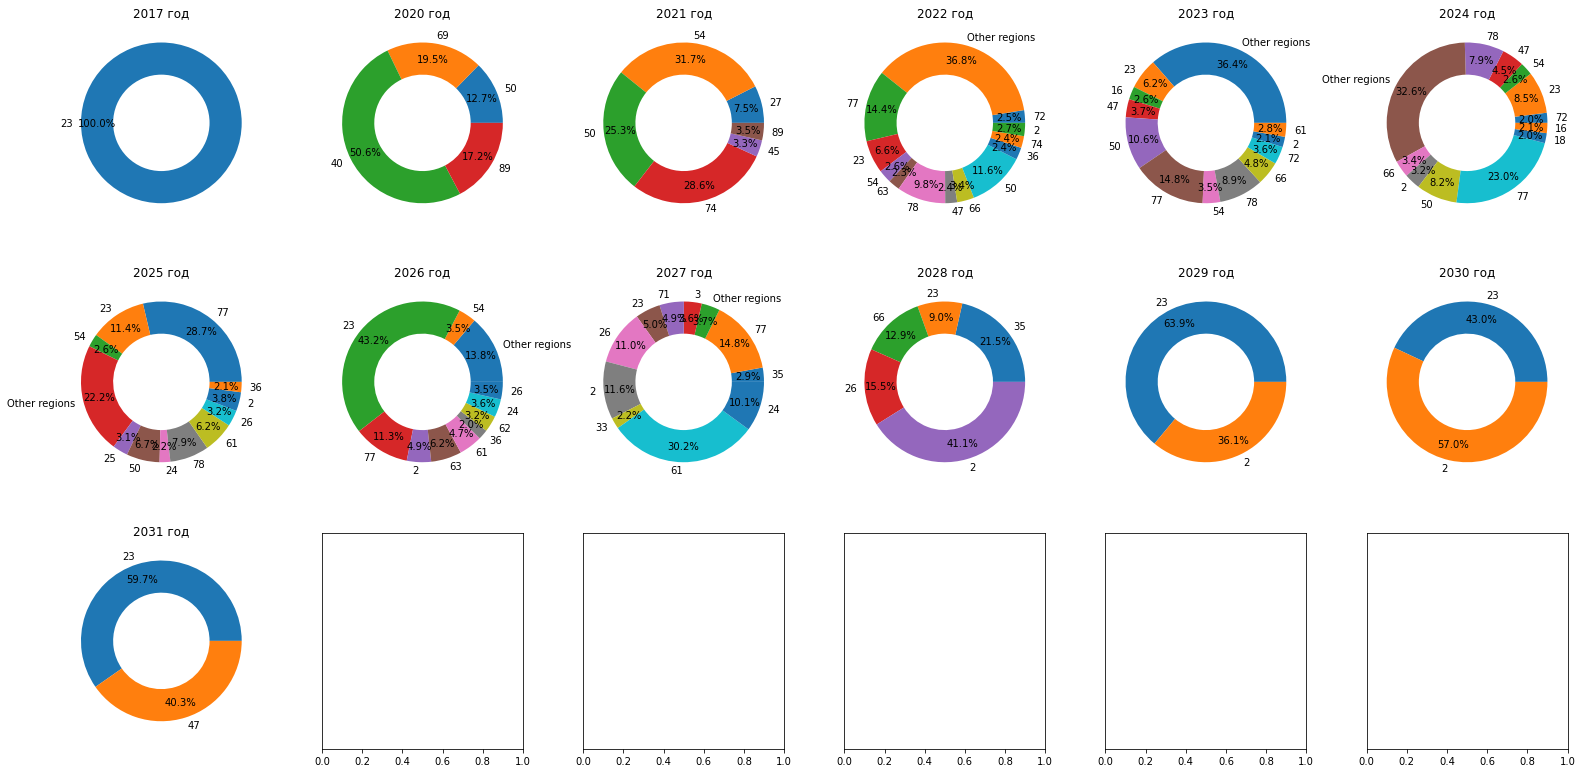

In [11]:
# Строим круговые диаграммы (бублики) по годам (на вход подаем количество бубликов по ширине)
visual.Make_pie_region_sqr_all_years(6)

In [12]:
# Строим круговую диаграмму ввода жилья в эксплуатацию по регионам в зависимости от года (на вход подаем год)
visual.Make_region_sqr_year(2024)

In [13]:
# Строим диаграмму sunburst ввода жилья в эксплуатацию по регионам и городам по выбранному году (подаем на вход)
visual.Make_region_city_square(2026)

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [14]:
visual.Make_scatter_avg_price_region()

In [15]:
# Строим график боксплот цен на жилье по регионам
visual.Make_box_avg_price_region()

In [16]:
# Строим график средних цен на жилье по регионам
visual.Make_bar_avg_price_region()

In [17]:
# Строим графики рассеивания по регионам по выбранному параметру
# Диаграмма рассеивания относительного количества парковочных мест для объектов по регионам
visual.Make_scatter_reg_other_param('objElemParkingCnt_otn')

# Еще интересны графики:

# Диаграмма рассеивания количества квартир в строящихся объектах по регионам
#visual.Make_scatter_reg_other_param('objFlatCnt')

# Диаграмма рассеивания сроков ввода в эксплуатацию объектов по регионам
#visual.Make_scatter_reg_other_param('objReady100PercDt')

# Диаграмма рассеивания количества парковочных мест для объектов по регионам в абсолютном значении
#visual.Make_scatter_reg_other_param('objElemParkingCnt')

# Диаграмма рассеивания количества детских площадок для строящихся объектов по регионам
#visual.Make_scatter_reg_other_param('objInfrstrPlaygrndCnt')

# Диаграмма рассеивания относительного количества детских площадок для строящихся объектов по регионам (количество площадок на квартиру)
#visual.Make_scatter_reg_other_param('objInfrstrPlaygrndCnt_otn')

# Диаграмма рассеивания количества спортивных площадок для строящихся объектов по регионам
#visual.Make_scatter_reg_other_param('objInfrstrSportGroundCnt')

# Диаграмма рассеивания количества спортивных площадок для строящихся объектов по регионам (количество площадок на квартиру)
#visual.Make_scatter_reg_other_param('objInfrstrSportGroundCnt_otn')

In [18]:
# Строим диаграмму рассеивания по выбранному региону (на вход подаем регион, название интересуемой колонки и при необходимости инвертировать оси графика - 1)
visual.Make_interact_scatter_reg(77, 'objReady100PercDt')


In [19]:
# Строим диаграмму рассеивания с выпадающим списком выбора параметра
visual.interact_scatter_reg(77)

interactive(children=(Dropdown(description='param', options=('objElemParkingCnt', 'objElemParkingCnt_otn', 'ob…

## График boxplot по цене и выбираемому параметру объекта

In [20]:
# Строим боксплот с выпадающим списком выбора параметра
visual.interact_boxplot_reg(77)


interactive(children=(Dropdown(description='param', options=('year_expl', 'wallMaterialShortDesc', 'objLkFinis…